# Lab 2: Cats vs Dogs

**Deadline**: Monday, June 06 at 5:00 PM

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Ali Khodadadi -- ali.khodadadi@mail.utoronto.ca

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1PAW7EYjezVMldBYuFhjJwcYcgrDcGha1?usp=sharing 

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    print(relevant_train_indices)
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
[40443, 35889, 38040, 36990, 16586, 35092, 42491, 20279, 22025, 39851, 342, 27297, 15145, 28946, 6169, 23235, 18061, 7236, 14320, 4662, 16014, 27407, 49105, 40932, 40069, 41062, 26689, 15606, 31199, 18814, 47038, 26642, 12475, 32936, 43336, 4266, 35770, 37369, 12798, 40331, 17855, 36944, 45192, 45783, 28442, 18563, 10705, 14494, 17, 6767, 26949, 42363, 21287, 26598, 14794, 31667, 6684, 21724, 9738, 48657, 31781, 26408, 6048, 7924, 21915, 7205, 7545, 27397, 43446, 5966, 28691, 43749, 39649, 20691, 25886, 49009, 10863, 3302, 6698, 12631, 11790, 30713, 34732, 7246, 27880, 45345, 37914, 38879, 43827, 37964, 25656, 31137, 2739, 36335, 44290, 2730, 25136, 27540, 16296, 18687, 33394, 39285, 19540, 45436, 49810, 15257, 46209, 47526, 34244, 41060, 12316, 36269, 7158, 331, 32813, 22487, 32372, 18787, 36087, 8507, 7017, 42620, 25087, 30606, 9609, 7485, 37184, 49079, 7987, 24741, 15793, 45678, 2657, 12428, 3087, 25055, 18983, 861, 33918, 22848, 31

In [ ]:
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

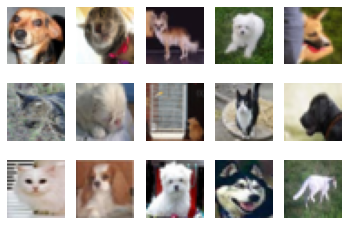

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
print("# of training:", len(train_loader))
print("# of validation:", len(val_loader))
print("# of test:", len(test_loader))

# of training: 8000
# of validation: 2000
# of test: 2000




---

*   The combined `cat` and `dog` classes include 8000 training examples.
*   The combined `cat` and `dog` classes include 2000 validation examples.
*   The combined `cat` and `dog` classes include 2000 testing examples.





### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?



---
We need the validation set because we need a set of examples to tune the hyperparameters of the classifier. Specifically, we would use the validation set to find the appropiate pause point for the back propagation process. If we judge the performance of our models using the training set loss/error instead of the validation set loss/error, we are risking to produce an overfitted model that has a biased (likely to be too optimistic) error rate estimate. 


## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
total = 0
for param in small_net.parameters():
  total += param.numel()
  print(param.shape)
print("small_net # of params: ", total,"\n")

total = 0
for param in large_net.parameters():
  total += param.numel()
  print(param.shape)
print("large_net # of params: ", total)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
small_net # of params:  386 

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
large_net # of params:  9705




---


*   The `small_net` has a total number of parameters of **386**
*   The `large_net` has a total number of parameters of **9705**




### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            print(outputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        # print(model_path)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    # print("{}_train_err.csv".format(model_path), train_err)
    # print("{}_train_loss.csv".format(model_path), train_loss)
    # print("{}_val_err.csv".format(model_path), val_err)
    # print("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?



---



```
# This is formatted as code
```



*   default `batch_size`: 64 
*   default `learning_rate`: 0.01
*   default `num_epochs`: 30



### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net,64,0.01,5)

Streaming output truncated to the last 5000 lines.
        -0.3378,  0.9073,  0.1872,  0.8079, -1.0101,  0.5191, -0.1796,  0.5358,
         0.3944,  0.7755, -0.1160, -1.3984,  0.6903, -0.2210,  1.1474,  0.1926,
        -0.3881,  0.4627, -0.2794, -0.3737, -0.6894, -0.1618,  0.4496,  0.7937,
        -0.0429, -0.6117, -0.0893, -0.7027,  0.7913, -0.7383, -0.1650, -0.5393,
         0.3002,  0.2118, -0.9588,  0.2837,  0.0891,  0.2954, -0.5394, -0.0868,
        -1.4642, -0.0152,  0.0844, -0.2979, -0.1170, -0.0353,  1.5018, -1.2432],
       grad_fn=<SqueezeBackward1>)
tensor([ 0.1315, -0.4348,  0.0738, -0.2551, -0.4793,  1.0772, -0.9808, -0.1695,
        -0.0842, -0.3847,  0.3206,  0.2761,  0.7200, -0.4415,  1.1624,  1.2739,
        -0.1704,  0.2791, -0.5552,  0.5916,  0.1194,  0.5460,  0.5810, -0.4411,
        -0.5228, -0.3698,  0.3589, -0.5381,  0.7057, -0.4027, -0.2647,  0.2009,
        -0.2959,  0.1142, -0.0908,  0.0282,  0.9350, -0.1137, -0.5861, -0.0967,
        -0.3155,  1.5580,  1.0847




---

The following files contain the training model (checkpoints) as .pt file at the end of each epoch (epoch 0-4): 
*   model_small_bs64_lr0.01_epoch0
*   model_small_bs64_lr0.01_epoch1
*   model_small_bs64_lr0.01_epoch2
*   model_small_bs64_lr0.01_epoch3
*   model_small_bs64_lr0.01_epoch4


---

The following files contain the train/test loss/err at epoch 4 as .csv file for later data visualization purpose: 

*   model_small_bs64_lr0.01_epoch4_train_err.csv
*   model_small_bs64_lr0.01_epoch4_train_loss.csv
*   model_small_bs64_lr0.01_epoch4_val_err.csv
*   model_small_bs64_lr0.01_epoch4_val_loss.csv


`Default Parameters`


*   Batch Size = 64
*   number of Epoches = 30
*   learning rate = 0.001

*training accuracy: 63.5%*
*validation accuracy: 63.3%*


---


After trying the default parameter, the curve graph shows that the validation accuracy is slightly above the training accuracy, which is a signal of overfitting training, as a result, I decided to decrease the batch size from 64 to 32 to create smaller batches (smaller batches might have more noises) to produce lower generalization error.

*   Batch Size = 32
*   number of Epoches = 30
*   learning rate = 0.001

*training accuracy: 64.0%*
*validation accuracy: 63.8%*


---
At the end of the accuracy learning curve, a slight fluctuating trend can still be observed on the graph, so I decided to reduce the learning rate to see if it can smoothen the curve and increase the accuracy.

*   Batch Size = 32
*   number of Epoches = 30
*   learning rate = 0.0001

*training accuracy: 61.8%*
*validation accuracy: 62.2%*


---
At the end of the accuracy learning curve, an increasing trend can still be observed on the graph, so I decided to increase the learning rate again to see if the curve can reach a plateau at the 30th epoch.

*   Batch Size = 32
*   number of Epoches = 30
*   learning rate = 0.0005

*training accuracy: 63.0%*
*validation accuracy: 62.7%*


---
Although the graph is slightly overfitting, at the end of the accuracy learning curve, an sudden increasing trend for both training and validation curve can be observed at the 29th epoch, so I decided to double the epoch number to see if the increasing trend will continue. 

*   Batch Size = 32
*   number of Epoches = 60
*   learning rate = 0.0005

*training accuracy: 62.5%*
*validation accuracy: 62.6%*


---
The following parameter acchives the highest accuracy in both training and validation dataset:
*   Batch Size = 32
*   number of Epoches = 30
*   learning rate = 0.001



### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# small_net train
train_net(small_net,64,0.01,30)

# large_net train
train_net(large_net,64,0.01,30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.323625, Train loss: 0.6015338678359985 |Validation err: 0.329, Validation loss: 0.6159196179360151
Epoch 2: Train err: 0.31625, Train loss: 0.5924326438903809 |Validation err: 0.3265, Validation loss: 0.6122309546917677
Epoch 3: Train err: 0.306875, Train loss: 0.5846264934539795 |Validation err: 0.3155, Validation loss: 0.5986098144203424
Epoch 4: Train err: 0.300375, Train loss: 0.5771103365421295 |Validation err: 0.332, Validation loss: 0.6103788241744041
Epoch 5: Train err: 0.299, Train loss: 0.5697660863399505 |Validation err: 0.315, Validation loss: 0.5948047786951065
Epoch 6: Train err: 0.290375, Train loss: 0.5612311720848083 |Validation err: 0.312, Validation loss: 0.5961621999740601
Epoch 7: Train err: 0.284375, Train loss: 0.5595348250865936 |Validation err: 0.3035, Validation loss: 0.582981706596911
Epoch 8: Train err: 0.2865, Train loss: 0.5548405268192291 |Validation err: 0.3



*   small_net's elapsed time: 127.38s
*   large_net's elapsed time: 132.51s



The `large_net` takes longer to train, as shown in Part 2(a) that  `large_net` has more number of parameters(**9705** parameters) than the `small_net`(**386** parameters), thus there are more biases and weights to compute/update in each layer.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

small_net training curve


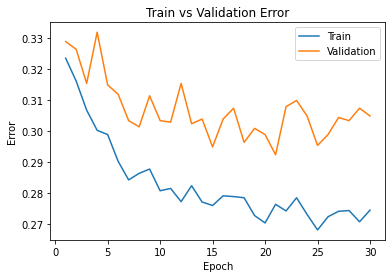

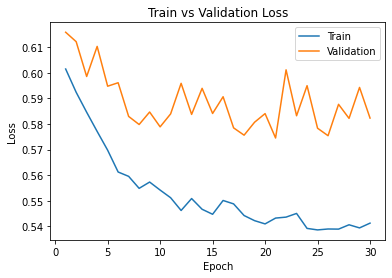

large_net training curve


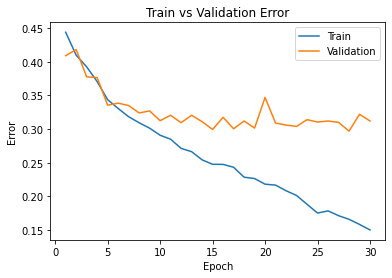

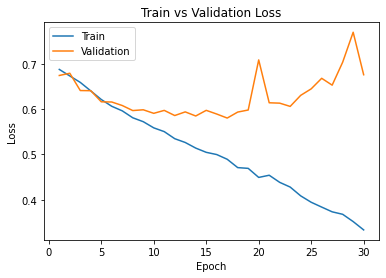

In [ ]:
print("small_net training curve")
model_path_s = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_s)

print("large_net training curve")
model_path_l = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_l)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.



---


`small_net` curve:
For small_net learning curve we can noticed that the training loss is slightly decreasing while the validation loss is fluctuating without a general decreasing trend. This shows that the model is not quite learning the data pattern, thus underfitting the validation dataset. 

`large_net` curve:
For large_net learning curve we can noticed an obvious downward trend for both training data and validation data at epoch 0-10. This shows that this model is working and 'learning' the data pattern. However, after epoch 0-10, although training loss/error is still decreasing at approximately the same rate, the validation loss/error stop decreasing. while the error remains approximately the same, the loss of the model increases at epoch 15, showing a sign of overfitting of model. 

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net,64,0.001,30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4835, Train loss: 0.6927897915840149 |Validation err: 0.453, Validation loss: 0.6923843417316675
Epoch 2: Train err: 0.4615, Train loss: 0.6921303782463074 |Validation err: 0.445, Validation loss: 0.6916248146444559
Epoch 3: Train err: 0.44675, Train loss: 0.6914011669158936 |Validation err: 0.438, Validation loss: 0.6908178273588419
Epoch 4: Train err: 0.4485, Train loss: 0.690577027797699 |Validation err: 0.4355, Validation loss: 0.6895228270441294
Epoch 5: Train err: 0.445375, Train loss: 0.6895351099967957 |Validation err: 0.4295, Validation loss: 0.6888805888593197
Epoch 6: Train err: 0.44625, Train loss: 0.6882763509750366 |Validation err: 0.425, Validation loss: 0.6870007533580065
Epoch 7: Train err: 0.44275, Train loss: 0.6867942891120911 |Validation err: 0.4235, Validation loss: 0.6853090189397335
Epoch 8: Train err: 0.43975, Train loss: 0.6850622372627259 |Validation err: 0.4265,

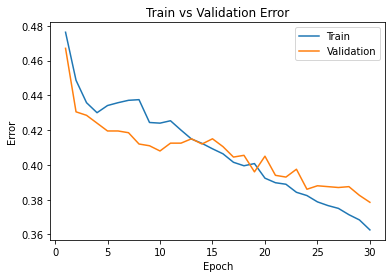

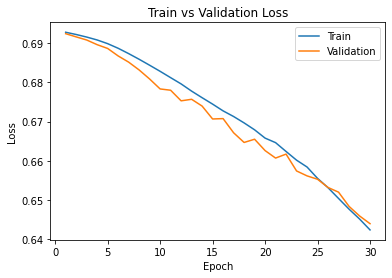

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)



---
The eplased time is **130.87s** (132.51s for 0.01 lr), thus takes shorter to train.

Lowering the learning rate makes training progress slowly as we are only making small updates to the weights in the networks in return for the more precise parameter updates (not time-efficient).


### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
large_net = LargeNet()
train_net(large_net,learning_rate=0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

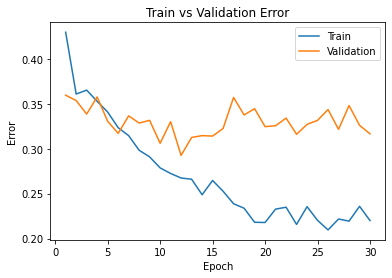

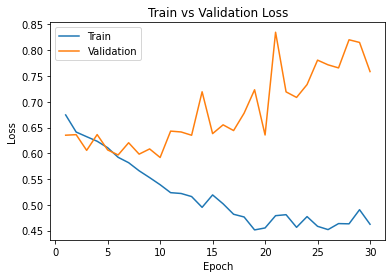

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)


---
The eplased time is **127.73s** (132.51s for 0.01 lr), thus takes shorter to train.

Increasing the learning rate causes undesirable divergent behavior in loss/error function (no decreasing trend for validation loss/error). In other words, we are using suboptimal set of biases and weights as the optimal values are missed due to the large learning rate.


### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net,batch_size=512)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

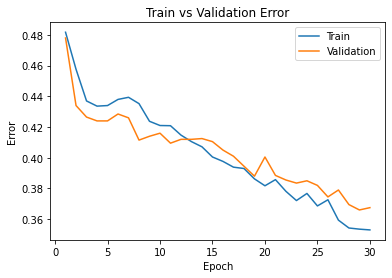

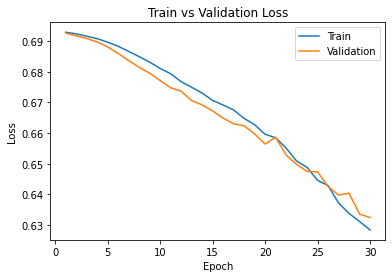

In [ ]:
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)


---
The eplased time is **112.61s** (132.51s for 64 batch size), thus takes shorter to train.

Increasing the batch size lead to inefficient training as shown on the graph. The training curve shows a mild decrease trend throughout the 30 epoches.


### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net,batch_size=16,learning_rate=0.01)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

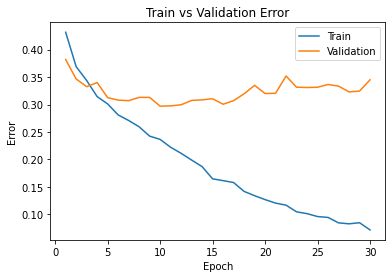

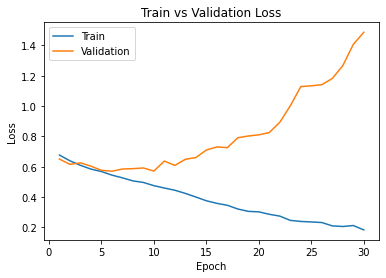

In [ ]:
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)


---
The eplased time is **179.17s** (132.51s for 64 batch_size), thus takes longer to train.

Lowering the batch size causes undesirable divergent behavior in train/validation curves. Having a small batch size might introduce too much 'noises' in the training process, thus cause the training loss significantly diverges with the validation loss. In other words, with a small batch size, it's challenging for our model to generalize to the unseen data. 


## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.



---


*   network: LargeNet
*   batch_size: 64
*   learning rate: 0.005

In part 2(a), lowering the learning rate shows a constant decreasing trend. As a result, using the same number of epoches, we can try to lower the learning rate to 0.005 (half as large as the default step) to see if smaller update step (more detailed adjustment) could result in a better model. 








### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net,learning_rate=0.005,batch_size=64, num_epochs = 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4525, Train loss: 0.6918498063087464 |Validation err: 0.429, Validation loss: 0.6890992466360331
Epoch 2: Train err: 0.441375, Train loss: 0.6870906538963318 |Validation err: 0.4175, Validation loss: 0.6815983336418867
Epoch 3: Train err: 0.419125, Train loss: 0.68000403881073 |Validation err: 0.414, Validation loss: 0.672147274017334
Epoch 4: Train err: 0.4075, Train loss: 0.6727880077362061 |Validation err: 0.4, Validation loss: 0.665028927847743
Epoch 5: Train err: 0.393125, Train loss: 0.665095594406128 |Validation err: 0.3895, Validation loss: 0.6580633874982595
Epoch 6: Train err: 0.375625, Train loss: 0.654603937625885 |Validation err: 0.378, Validation loss: 0.6485581416636705
Epoch 7: Train err: 0.372375, Train loss: 0.6454356808662415 |Validation err: 0.3775, Validation loss: 0.6415849085897207
Epoch 8: Train err: 0.35675, Train loss: 0.6330658750534057 |Validation err: 0.3545, V

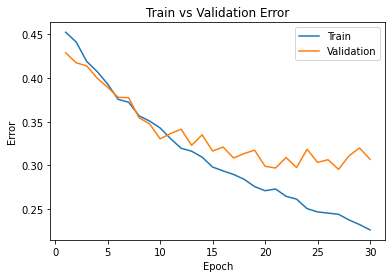

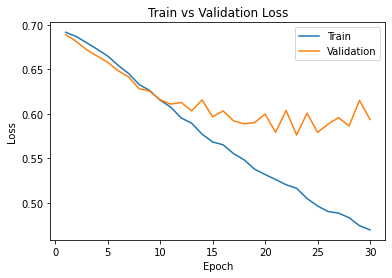

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.005, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.



---
Based on the parameters suggested in part(a):

*   network: LargeNet
*   batch_size: 32
*   learning rate: 0.005

In part 2(d), lowering the batch size helps the training data to overfit the model, which means that the training model is indeed learning the data pattern. As a result, we could attempt to lower the batch size to 32. This size is still larger than 16 so the model does not produce overfit pattern as shown in part 2(d).





### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net,learning_rate=0.005,batch_size=32, num_epochs = 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.451125, Train loss: 0.6895513644218445 |Validation err: 0.4235, Validation loss: 0.6799672160829816
Epoch 2: Train err: 0.41475, Train loss: 0.6770808370113373 |Validation err: 0.426, Validation loss: 0.6783659694686769
Epoch 3: Train err: 0.399, Train loss: 0.6652117266654968 |Validation err: 0.399, Validation loss: 0.6516326277975052
Epoch 4: Train err: 0.3785, Train loss: 0.6488407542705535 |Validation err: 0.393, Validation loss: 0.6554539033344814
Epoch 5: Train err: 0.357, Train loss: 0.6303725736141205 |Validation err: 0.342, Validation loss: 0.6204922937211537
Epoch 6: Train err: 0.339, Train loss: 0.6117297095060349 |Validation err: 0.348, Validation loss: 0.6352075660039508
Epoch 7: Train err: 0.323375, Train loss: 0.5982237335443497 |Validation err: 0.3235, Validation loss: 0.6010712650087144
Epoch 8: Train err: 0.316375, Train loss: 0.5813896104097366 |Validation err: 0.3275, V

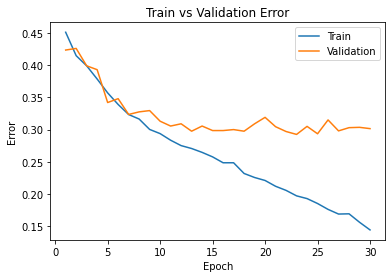

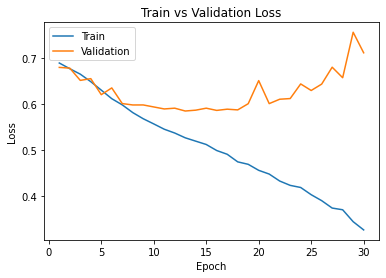

In [ ]:
model_path = get_model_name("large", batch_size=32, learning_rate=0.005, epoch=29)
plot_training_curve(model_path)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=64, learning_rate=0.005, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).



---
I chose the set of parameters from part 4(a).


Although the set of parameters that I chose does not output the global best validation error (28.2% error and 0.529 loss from epoch 13 of the default parameter), it does produce a relatively small validation error/loss (29.6% error and 0.578 loss). Having the same batch_size as the default parameters, I decided to lower the learning rate to have a more precise step update such that the overfitting pattern at 15-30 epoches is eliminated. This model is also not overfitted to the training dataset, thus would lead to more stable performance throughout the overall dataset.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
criterion = nn.BCEWithLogitsLoss()
error,loss = evaluate(net,test_loader,criterion)
print("Test classification error is ", error)

Test classification error is  0.292


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

The test classification error (0.293) performs better than the validation error(0.296). However, I expected the test error is higher than the validation error as the model's hyperparameters has been tuned specifically according to the validation dataset, not the testing dataset. As a result, due to the unseen nature of the testing dataset, I would expected the final output set of parameters will adapt better to the validation dataset than the testing set.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?



---


Testing dataset is what we used to provide the estimate for the final model's generalization ability. We want to avoid the possibility of overturning (which will result in test dataset overfitting and we would lose our metrics for evaluating the model's generalization ability).Therefore, if we update the model multiple times according to the testing dataset, to better evaluate the latest version of model, we would have to find new testing set to compute the generalization ability of the updated model. This is important for our model to be able operate in a real-life setting. 

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision import datasets, transforms
# import matplotlib.pyplot as plt # for plotting
# import torch.optim as optim

# torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(3*32*32, 100)
        self.layer2 = nn.Linear(100, 1)
    def forward(self, img):
        flattened = img.view(-1, 3*32*32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2

catdog = ANN()

    
# simplified training code to train `catdog` on the "small digit recognition" task
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(catdog.parameters(), lr=0.001, momentum=0.9)


for (image, label) in train_loader:
  for i in range(len(label)):
    actual = torch.tensor(label[i].item()==3).reshape([1,1]).type(torch.FloatTensor)

    # catdog prediction
    out = catdog(image[i].view(-1,3*32*32)) # step 1-2
    # update the parameters based on the loss
    loss = criterion(out, actual)      # step 3
    loss.backward()              # step 4 (compute the updates for each parameter)
  optimizer.step()              # step 4 (make the updates for each parameter)
  optimizer.zero_grad()              # a clean up step for PyTorch

# computing the error and accuracy on the training set
error = 0
total = 0
for (image, label) in train_loader:
  for i in range(len(label)):
    actual = label[i].item()
    prob = torch.sigmoid(catdog(image[i]))
    if (prob < 0.5 and label[i].item()==3) or (prob >= 0.5 and label[i].item()==5):
        error += 1
    total += 1

print("Training Error Rate:", error/total)
print("Training Accuracy:", 1 - error/total)


# computing the error and accuracy on a test set
error = 0
total = 0
for (image, label) in test_loader:
  for i in range(len(label)):
    actual = label[i].item()

    prob = torch.sigmoid(catdog(image[i]))
    if (prob < 0.5 and label[i].item() <4) or (prob >= 0.5 and label[i].item() >4):
        error += 1
    total += 1
print("Test Error Rate:", error/total)
print("Test Accuracy:", 1 - error/total)

Training Error Rate: 0.370375
Training Accuracy: 0.629625
Test Error Rate: 0.385
Test Accuracy: 0.615
